# STA 141B Assignment 4

Due __Feb 22, 2019__ by 11:59pm. Submit by editing this file, committing the changes with git, and then pushing to your private GitHub repo for the assignment. This assignment will be graded according to the class rubric.

Please do not rename this file or delete the exercise cells, because it will interfere with our grading tools. Put your answers in new cells after each exercise. You can make as many new cells as you like. Use code cells for code and Markdown cells for text. Answer all questions with complete sentences.

The purpose of this assignment is to practice scraping data from web pages.

In [2]:
# Our usual data science tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import lxml.html as lx
import requests
import requests_cache
requests_cache.install_cache("../sfchronicle")
import time
import re
import nltk
import nltk.corpus
nltk.download('stopwords')
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# References: 

# https://stackoverflow.com/questions/11860476/how-to-unnest-a-nested-list: Used it to unlist my nested list in 1.4

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rohanmalhotra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## The San Francisco Chronicle

In this assignment, you'll scrape text from [The San Francisco Chronicle](https://www.sfchronicle.com/) newspaper and then analyze the text.

The Chronicle is organized by category into article lists. For example, there's a [Local](https://www.sfchronicle.com/local/) list, [Sports](https://www.sfchronicle.com/sports/) list, and [Food](https://www.sfchronicle.com/food/) list.

The goal of exercises 1.1 - 1.3 is to scrape articles from the Chronicle for analysis in exercise 1.4.

__Exercise 1.1.__ Write a function that extracts all of the links to articles in a Chronicle article list. The function should:

* Have a parameter `url` for the URL of the article list.

* Return a list of article URLs (each URL should be a string).

Test your function on 2-3 different categories to make sure it works.

Hints:

* Be polite and save time by setting up [requests_cache](https://pypi.python.org/pypi/requests-cache) before you write your function.

* You can use any of the XML/HTML parsing packages mentioned in class. Choose one and use it throughout the entire assignment.

In [3]:
def get_articles(url):
    
    ''' Function takes in a page from the sf chronicle and returns, 
    every article on that page'''
    
    try:
        
        # Get the website
        response = requests.get(url)
        time.sleep(2)
        response.raise_for_status()
    
        # Format it like an html 
        html = lx.fromstring(response.text)
        html.make_links_absolute(url)
    
        # Get the articles on the page 
        main_articles = html.xpath("//h2[contains(@class, 'headline')]/a/@href") # Gets the main articles for each section
        related_articles = html.xpath("//div[contains(@class,'item rel-links')]/h4/a/@href") # Gets other articles related to the main one 
        final = set(main_articles + related_articles)
        final = list(final)
    
        # Since articles have a .php at the end of the link i will only extract those to make sure i get articles only
        articles = [item for item in final if "php" in item]
    
    except:
        print("The url was either invalid or the incorrect format")
        return None
    
    return articles
    

In [4]:
# Buisness articles: 
biz = get_articles("https://www.sfchronicle.com/business/")
biz[:5]

['https://www.sfchronicle.com/business/article/Amazon-dumps-NYC-headquarters-and-its-promised-13617774.php',
 'https://www.sfchronicle.com/news/world/article/Asian-stocks-rally-on-hope-of-further-China-US-13624395.php',
 'https://www.sfchronicle.com/realestate/article/Designer-Profile-Lowell-Strauss-of-Amalfi-West-13620501.php',
 'https://www.sfchronicle.com/business/article/Long-winding-road-led-to-get-touch-registration-12617780.php',
 'https://www.sfchronicle.com/bayarea/article/CleanPowerSF-tripling-households-served-with-13618155.php']

In [5]:
# Sports articles: 
sports = get_articles("https://www.sfchronicle.com/sports/")
sports[:5]

['https://www.sfchronicle.com/49ers/article/49ers-GM-John-Lynch-will-be-the-one-to-watch-13484514.php',
 'https://www.sfchronicle.com/sports/golf/article/Hailstorm-slams-Pebble-Beach-during-final-round-13605371.php',
 'https://www.sfchronicle.com/collegesports/article/USF-uses-late-rally-to-overcome-Pepperdine-29-13618708.php',
 'https://www.sfchronicle.com/49ers/article/Will-49ers-put-franchise-tag-on-kicker-Robbie-13626054.php',
 'https://www.sfchronicle.com/athletics/article/A-s-great-Rickey-Henderson-was-gung-ho-to-13622452.php']

In [6]:
# lifestyle  articles:
lifestyle = get_articles("https://www.sfchronicle.com/lifestyle/")
lifestyle[:5]

['https://www.sfchronicle.com/homeandgarden/article/Modern-Carmel-Valley-home-welcomes-land-and-sky-12232711.php',
 'https://www.sfchronicle.com/style/article/Asian-Art-Museum-shows-the-kimono-s-13594758.php',
 'https://www.sfchronicle.com/travel/article/Podcast-Ultrarunner-Dean-Karnazes-on-recovery-13595254.php',
 'https://www.sfchronicle.com/style/article/Galas-galore-CMPC-celebrates-new-hospital-13608478.php',
 'https://www.sfchronicle.com/travel/article/Lake-Tahoe-houses-sit-vacant-while-locals-13601651.php']

__Exercise 1.2.__ Write a function that extracts data from a Chronicle article. The function should:

* Have a parameter `url` for the URL of the article.

* Return a dictionary with keys for:
    + `url`: The URL of the article.
    + `title`: The title of the article.
    + `text`: The complete text of the article.
    + `author`: The author's name (if available) or a suitable missing value.
    + `date`: The date and time the article was published.
    + `date_updated`: The date and time the article was last updated (if available) or a suitable missing value.

For example, for [this article](https://www.sfchronicle.com/homeandgarden/article/Gardenlust-looks-at-best-21st-century-13580871.php) your function should return a dictionary with the form:
```js
{'url': 'https://www.sfchronicle.com/homeandgarden/article/Gardenlust-looks-at-best-21st-century-13580871.php',
 'title': '‘Gardenlust’ looks at best 21st century gardens in the world',
 'text': 'The book...',
 'author': 'Pam Peirce',
 'date': '2019-02-01T18:02:33+00:00',
 'date_updated': '2019-02-01T18:12:53+00:00'}
```
The value of the `text` field is omitted here to save space. Your function should return the full text in the `text` field.

Hints:

* Many parsing packages allow you to delete elements from an HTML document. Deleting elements is one way to avoid extracting unwanted tags.
* You can union multiple XPath paths with `|`.

In [7]:
def get_article_info(article):
   
    ''' Function takes in a link of an article from the sf chronicle and extracts features
        such as author,title,date published and updated from that article'''
    
    response = requests.get(article)
    html = lx.fromstring(response.text)
    
    # Getting the title
    try:
        title = html.xpath("//h1[contains(@class, 'header-title')]|//h1[contains(@class,'headline entry-title')]")[0]
        title = title.text
    
    except:
        title = None

    # Getting the text of the article 
    try:
        contents = html.xpath("//section[contains(@class, 'body')]//p|//div[contains(@class, 'article-body')]//p")
        all_text = [content.text_content() for content in contents]
        all_text = "".join(all_text)
        
    except:
        all_text = None

    # Author 
    try:
        author = html.xpath("//span[@class ='header-authors-name']|//p[contains(@class,'byline')]//a")
        if len(author) == 2:
            author1 = author[0].text_content()
            author2 = author[1].text_content()
            if author1 == author2:
                author = author[0].text_content()
            else:
                author = author1 + " and " + author2
        else:
            author = author[0].text_content()
    except:
        author = None
        try:
            author = html.xpath("//div//span[@class = 'header-byline']")[0]
            author = author.text_content().strip()
            author = re.sub(r'^By ','', author)
            if author == '':
                author = None     
        except:
            author = None

    # Dates
    get_date = html.xpath("//time/@datetime")

    # Published Date 
    try:
        pub_date = get_date[0]
    
    except:
        pub_date = None

    # Updated date
    try:
        updated = get_date[1]
    
    except:
        updated = None
    
    return {"url": article, "title": title, "text": all_text, "author": author, "date": pub_date, "date_updated": updated}

# Tests:
# get_article_info("https://www.sfchronicle.com/homeandgarden/article/Gardenlust-looks-at-best-21st-century-13580871.php")
# get_article_info("https://www.sfchronicle.com/politics/article/Trump-administration-cancels-funding-for-CA-13628908.php")
# get_article_info("https://www.sfchronicle.com/food/article/Remodel-creates-an-airy-house-of-mirth-for-family-11297009.php")


__Exercise 1.3.__ Use your functions from exercises 1.1 and 1.2 to get data frames of articles for the "Biz+Tech" category as well as two other categories of your choosing (except for "Vault: Archive", "Podcasts", and "In Depth").

Add a column to each that indicates the category, then combine them into one big data frame. Clean up the data, stripping excess whitespace and converting columns to appropriate dtypes.

The `text` column of this data frame will be your corpus for natural language processing in exercise 1.4.

In [8]:
# Using article categories I tested my get_articles function on in 1.1 
# biz
biz_info = [get_article_info(art) for art in biz]
biz_df = pd.DataFrame(biz_info)
biz_df["category"] = "Biz + tech"

In [9]:
# Sports
sports_info = [get_article_info(art) for art in sports]
sports_df = pd.DataFrame(sports_info)
sports_df["category"] = "sports"

In [10]:
# lifestyle
lifestyle_info = [get_article_info(art) for art in lifestyle]
lifestyle_df = pd.DataFrame(lifestyle_info)
lifestyle_df["category"] = "lifestyle"

In [16]:
# Combining the data frames
full_df = pd.concat([lifestyle_df,sports_df,biz_df])
full_df = full_df.reset_index(drop = True)
full_df["url"][0]

'https://www.sfchronicle.com/homeandgarden/article/Modern-Carmel-Valley-home-welcomes-land-and-sky-12232711.php'

In [17]:
# Cleaning the data frame
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 7 columns):
author          139 non-null object
date            135 non-null object
date_updated    111 non-null object
text            141 non-null object
title           141 non-null object
url             141 non-null object
category        141 non-null object
dtypes: object(7)
memory usage: 7.8+ KB


Every column should be a string,but date and date_updated as they should be date time objects so those are the only  two types that I will change as the rest are what I want them to be 

In [22]:
# Converting the data types
full_df["date"] = pd.to_datetime(full_df["date"])
full_df["date_updated"] = pd.to_datetime(full_df["date_updated"])

In [19]:
# Checking the titles to see if theres more patterns
no_title = full_df[full_df["title"].isna()]

Added pattern for titles under the class of headline entry-title, and now every post has a title 

In [20]:
# Checking the author's to see if theres more patterns 
no_author =  full_df[full_df["author"].isna()]

There was a pattern in which the authors in some link would be "by ... " so incorporated that pattern into my function 
and i clean it within the function so i get rid of the "by" and get just the author name, but there seems to be 2 posts with no authors still after checking the links i did not see any author

###### Overall, I feel my data frame came out formatted right mainly due to the way i scraped the data,only changes needed were converting the date and date_updated to date time objects and  I got more patterns to get almost all the data for each article

In [23]:
full_df

,author,date,date_updated,text,title,url,category
0,Laura Mauk-Caines,2017-09-27 16:44:41,2017-09-27 17:44:41,"If you’ve never seen a fox in a fig tree, you ...",Modern Carmel Valley home welcomes land and sky,https://www.sfchronicle.com/homeandgarden/arti...,lifestyle
1,Tony Bravo,2019-02-08 17:41:55,2019-02-12 22:52:42,An ancient garment is having a major moment in...,Asian Art Museum shows the kimono’s internatio...,https://www.sfchronicle.com/style/article/Asia...,lifestyle
2,Gregory Thomas,2019-02-06 21:16:50,NaT,"For more stories like this, check out The Chro...",Podcast: Ultrarunner Dean Karnazes on recovery...,https://www.sfchronicle.com/travel/article/Pod...,lifestyle
3,Catherine Bigelow,2019-02-18 18:25:10,2019-02-18 18:26:03,Hospitals are not always places of joy. But a ...,"Galas galore: CPMC celebrates new hospital, SF...",https://www.sfchronicle.com/style/article/Gala...,lifestyle
4,Dave Zook,2019-02-08 18:43:29,2019-02-08 19:09:12,"For more stories like this, check out The Chro...",Lake Tahoe houses sit vacant while locals stru...,https://www.sfchronicle.com/travel/article/Lak...,lifestyle
5,Tom Stienstra,2019-02-08 19:42:27,2019-02-08 19:45:59,"In Paradise, Oroville and the surrounding regi...",Feather Falls: California’s prettiest waterfal...,https://www.sfchronicle.com/travel/article/Fea...,lifestyle
6,Brenda Wong Aoki,2019-02-14 20:00:53,2019-02-16 19:18:08,"In 1897, Emperor Meiji sent my grandfather to ...","How Brenda Wong Aoki rocks the kimono — past, ...",https://www.sfchronicle.com/style/article/How-...,lifestyle
7,Tom Stienstra,2019-02-15 19:28:51,2019-02-19 17:44:01,You could leave right now and in a matter of h...,Where’s the closest place to find snow near Sa...,https://www.sfchronicle.com/travel/article/Whe...,lifestyle
8,Julie Chai,2015-07-10 07:01:00,NaT,Boasting gorgeous rosettes painted in frosty b...,Beauty and brawn: Gotta get agave,https://www.sfchronicle.com/homeandgarden/arti...,lifestyle
9,Catherine Bigelow,2019-02-20 17:39:32,2019-02-20 17:41:22,"Nearly 1,200 hearts burst with joy the night b...",Hearts in San Francisco gala breaks a record f...,https://www.sfchronicle.com/style/article/Hear...,lifestyle


__Exercise 1.4.__  What topics has the Chronicle covered recently? How does the category affect the topics? Support your analysis with visualizations.

Hints:

*   The [nltk book](http://www.nltk.org/book/) may be helpful here.

*   This question will be easier to do after we've finished NLP in class.

In [24]:
# All the stop words from each category defined below that i found from the initial graphs for each category

biz_sw = ['said','new',"san","you","also","pg","would","year","could","one","percent","000","city","get","companies"]
sports_sw = ["two","time","last","first","three","10","12"]
lifestyle_sw = ["www","like","says","com",]
all_sw = biz_sw + sports_sw + lifestyle_sw

def tokenize(text):
    
    '''Function will take in a text, and returns a list of all the words, not including stop 
    words in that text'''
    
    # Get all words in the text
    all_words = re.findall('\w+',text) 
    
    # Get all unique words, as some words may be the same but one might be a different case
    uni_words = [] 
    for word in all_words:
        uni_words.append(word.lower())
        

    # Get rid of all the stop words
    sw = nltk.corpus.stopwords.words("english")
    sw = sw + all_sw
    
    # Get words that aren't stop words 
    ns_words = []
    for i in uni_words:
        if i not in sw and len(i) > 1:
            ns_words.append(i)
   
    return ns_words

###### Getting the frequency of the most common words per category and graphing it

In [25]:
all_lists = [tokenize(i) for i in full_df["text"]]
all_lists = list(chain(*all_lists)) # used to unlist the list of lists
freqdist_all = nltk.FreqDist(all_lists)

In [26]:
biz_lists = [tokenize(i) for i in biz_df["text"]]
biz_lists = list(chain(*biz_lists)) 
freqdist_biz = nltk.FreqDist(biz_lists)

In [27]:
sports_lists = [tokenize(i) for i in sports_df["text"]]
sports_lists = list(chain(*sports_lists))
freqdist_sports = nltk.FreqDist(sports_lists)

In [28]:
lifestyle_lists = [tokenize(i) for i in lifestyle_df["text"]]
lifestyle_lists = list(chain(*lifestyle_lists))
freqdist_lifestyle = nltk.FreqDist(lifestyle_lists)

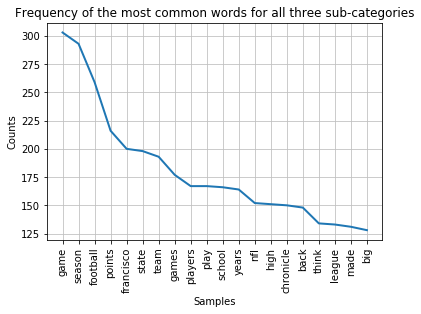

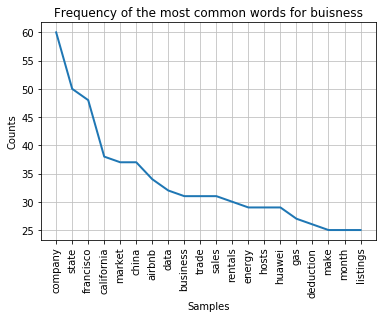

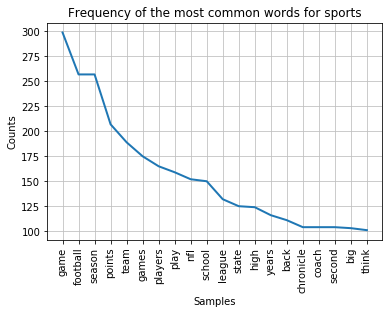

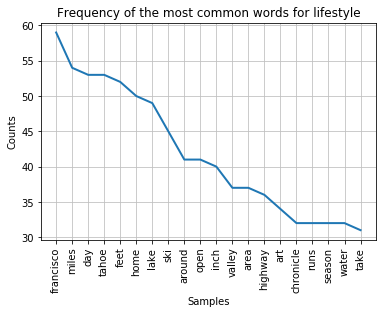

In [29]:
plt.title("Frequency of the most common words for all three sub-categories")
freqdist_all.plot(20)

plt.title("Frequency of the most common words for buisness")
freqdist_biz.plot(20)

plt.title("Frequency of the most common words for sports")
freqdist_sports.plot(20)

plt.title("Frequency of the most common words for lifestyle")
freqdist_lifestyle.plot(20)

##### Topics covered recently by the Chronicle:
Looking at the first figure, frequency of the most common words for all three sub-categories , Amongst those three categroires the most occured phrases were game,season,football,points. This therefore leads me to believe the Chronicle has been covering a lot of sports lately, which makes sense to me as since i am a sports fanatic i know there's alot going on in the sports world right now. Also, there's alot of information on san francisco so the chronicle has been covering that alor pretty recently which makes sense as the newspaper is based in san francisco. 

##### The category effect on the topics:

I believe, the category has a big effect on the topic of the words.  As seen when i dissect ecah sub category, there is not much overlap among the topics, as mentioned above words like game,season,football and points are only under the sports section, but a small amount of words like francisco overlap among the lifestyle and buisness categories. Furthermore, this leads me to the conclusion that, for the most part each sub-category will have its own unique topic that it will cover which will not be presented within other sub-categories.